This tutorial will show how to use and modify the data generator pack for Tacton.
Data objects that are relevant for this project are:
C_data - Combination data, 
D_data - Discount data, 
p_data - probability data, 
deal_data - Quote outcome. 
For more information regarding the algorithms behind the data generator: 
https://docs.google.com/document/d/10QUrTwTu61wxq57S-zQgsrRc2BtC6QuKa8mXj4Q4f84/edit

In [9]:
import numpy as np
from matplotlib import pylab as plt
from generate_cpq_data_class import *
import psutil
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [11]:
print("virtual memory used: ", psutil.virtual_memory()[2], "%")


virtual memory used:  56.6 %


The Generator_pack creates a C-gen (Combinations/dimensions-generator), D_gen (Discount-generator), a P (Probability function) and a corresponding P_gen (Probability-generator).

We start this tutortial by initiate a Generator_pack G. discount_max, discount_min, discount_mean, discount_std are parameters for the distribution of the discount data (truncated normal distribution). mean_p and max_p are parameters for the probability distribution. 

In [12]:
G=Generator_pack(discount_max = 0.4, discount_min=0, discount_mean = 0.15, discount_std = 0.2, mean_p = 0.2,
                  max_p = 0.4)

#C_3 = [3,2,0,2,2,2]
#G.set_C(C_3, p=lambda d:np.sin(d*2*np.pi/0.4), n= lambda: 1000, d_dist= lambda nr: 0.4*np.random.rand(nr))

In [ ]:
import pickle

training_data = pickle.load( open( "training_data.p", "rb" ) )
C_train = training_data['C_train']
D_train = training_data['D_train']
p_train = training_data['p_train']
deal_train = training_data['deal_train']

test_data = pickle.load( open( "test_data.p", "rb" ) )
C_test = test_data['C_test']
D_test = test_data['D_test']
p_test = test_data['p_test']
deal_test = test_data['deal_test']

### Generate training and test data from G.

In [13]:
#import pickle
#import os

C_train, D_train, p_train, deal_train = G.generate_data(copyfunction=lambda: int(np.maximum(0,np.random.normal(100,0.2))))
#training_data = {'C_train': C_train, "D_train": D_train, "p_train": p_train, "deal_train": deal_train}
#pickle.dump( training_data, open( "training_data.p", "wb" ) )

Generated data:  611312 / 611312


In [14]:
C_test, D_test, p_test, deal_test = G.generate_data(copyfunction=lambda: int(np.maximum(0,np.random.normal(100,0.2))))
#test_data = {'C_test': C_test, "D_test": D_test, "p_test": p_test, "deal_test": deal_test}
#pickle.dump( test_data, open( "test_data.p", "wb" ) )

Generated data:  611360 / 611360


Define the model shell

In [48]:
def custom_loss_function(y, p_y):
    #logloss
    return -p_y.log_prob(y)

eps = 0.000001
input_shape = (30,)

def create_model2(input_shape=(30,)):
    C = tf.keras.layers.Input(shape=input_shape, name='C_data')
    dis = tf.keras.layers.Input(shape=(1,), name='D_data')

    k_ = tf.keras.layers.Dense(20, name='k_layer')(C)
    m_ = tf.keras.layers.Dense(20, name='m_layer')(C)

    #k_ = tf.keras.layers.Dense(10, activation='relu', name='k_layer')(C)
    #k_ = tf.keras.layers.Dense(10, name='k_layer2')(k_)

    #m_ = tf.keras.layers.Dense(100, activation='relu', name='m_layer')(C)
    #m_ = tf.keras.layers.Dense(1000, name='m_layer2')(m_)

    z = tf.math.multiply(k_,dis, name='multiply_k')

    z = tf.math.add(z,m_,name='add_m')
    z = tf.keras.layers.Activation('sigmoid',name='h')(z)
    #z = tf.keras.layers.Dense(100,activation='sigmoid')(z)

    z = tf.keras.layers.Dense(1)(z)

    p = tf.keras.layers.Lambda(lambda t: tf.sigmoid(t) * (1.0 - eps) + eps / 2)(z)
    Out = tfp.layers.DistributionLambda(lambda t: tfd.Bernoulli(probs=t))(p)

    model = tf.keras.models.Model(inputs=[dis,C], outputs=Out)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001, decay=0), loss=custom_loss_function, metrics=['mae'])
    return model

In [16]:
def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    return -np.log(p*true_label + (1-p)*(1- true_label))

### Define the model M

In [49]:
from MLmodel import*
M = MLmodel(model_shell=create_model2())
M.model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C_data (InputLayer)             [(None, 30)]         0                                            
__________________________________________________________________________________________________
k_layer (Dense)                 (None, 20)           620         C_data[0][0]                     
__________________________________________________________________________________________________
D_data (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_multiply_k_15 (Tens [(None, 20)]         0           k_layer[0][0]                    
                                                                 D_data[0][0]              

### Train the model.

In [50]:

test_size = 50000
C_val = C_test[:test_size]
D_val = D_test[:test_size]
deal_val = deal_test[:test_size]
p_val = p_test[:test_size]
print("true logloss train set: ", np.mean(logloss(deal_train,p_train)))
print("true logloss validation set: ", np.mean(logloss(deal_val,p_val)))
M.train(C_train, D_train, deal_train, C_val, D_val, deal_val, batch_size=100, verbose=1, early_stopping_patience=15)

true logloss train set:  0.36471088169276145
true logloss test set:  0.36694466644848245
training starts
Train on 611312 samples, validate on 50000 samples
Epoch 1/500
611312/611312 [==============================] - 17s 28us/sample - loss: 0.3877 - mae: 0.2421 - val_loss: 0.3808 - val_mae: 0.2365
Epoch 2/500
611312/611312 [==============================] - 16s 25us/sample - loss: 0.3783 - mae: 0.2359 - val_loss: 0.3790 - val_mae: 0.2418
Epoch 3/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3769 - mae: 0.2350 - val_loss: 0.3778 - val_mae: 0.2391
Epoch 4/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3760 - mae: 0.2347 - val_loss: 0.3771 - val_mae: 0.2360
Epoch 5/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3753 - mae: 0.2347 - val_loss: 0.3766 - val_mae: 0.2367
Epoch 6/500
611312/611312 [==============================] - 15s 24us/sample - loss: 0.3747 - mae: 0.2347 - val_loss: 0.3761 - va

611312/611312 [==============================] - 15s 25us/sample - loss: 0.3679 - mae: 0.2328 - val_loss: 0.3708 - val_mae: 0.2340
Epoch 57/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3679 - mae: 0.2323 - val_loss: 0.3708 - val_mae: 0.2349
Epoch 58/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3678 - mae: 0.2322 - val_loss: 0.3708 - val_mae: 0.2328
Epoch 59/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3678 - mae: 0.2321 - val_loss: 0.3711 - val_mae: 0.2292
Epoch 60/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3678 - mae: 0.2321 - val_loss: 0.3708 - val_mae: 0.2341
Epoch 61/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3678 - mae: 0.2322 - val_loss: 0.3707 - val_mae: 0.2386
Epoch 62/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3677 - mae: 0.2327 - val_loss: 0.3707 - val_mae: 0.2349
Epoch

Epoch 113/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3667 - mae: 0.2324 - val_loss: 0.3702 - val_mae: 0.2319
Epoch 114/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3668 - mae: 0.2322 - val_loss: 0.3707 - val_mae: 0.2296
Epoch 115/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3667 - mae: 0.2316 - val_loss: 0.3702 - val_mae: 0.2304
Epoch 116/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3667 - mae: 0.2316 - val_loss: 0.3705 - val_mae: 0.2263
Epoch 117/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3667 - mae: 0.2318 - val_loss: 0.3700 - val_mae: 0.2331
Epoch 118/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3667 - mae: 0.2318 - val_loss: 0.3701 - val_mae: 0.2327
Epoch 119/500
611312/611312 [==============================] - 15s 25us/sample - loss: 0.3667 - mae: 0.2319 - val_loss: 0.3701 - v

### Validation score (logloss) ´

In [56]:
pred_p_val = M.probability(C_val,D_val)
print("true logloss validation set: ", np.round(np.mean(logloss(deal_val,p_val)),4))
print("ML model logloss validation set: ", np.round(np.mean(logloss(deal_val,pred_p_val)),4))

true logloss validation set:  0.3669
ML model logloss validation set:  0.3699


Generated data:  101 / 101
Generated data:  101 / 101
Generated data:  101 / 101


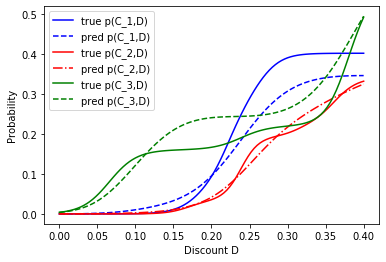

In [54]:
nr=101
dl = np.linspace(0,0.4,nr)

C_1 = one_hot([1,1,1,1,1,1])
C_1_list = np.tile(np.expand_dims(np.array(C_1),0),(nr,1))
pred_p1 = M.probability(C_1_list, dl)
true_p1 = G.P.p(C_1_list,dl)

plt.plot(dl,true_p1, c='b', label='true p(C_1,D)')
plt.plot(dl,pred_p1, c='b', ls='--', label='pred p(C_1,D)')

C_2 = [3,2,0,2,6,2]
C_2oh = one_hot(C_2)
C_2_list = np.tile(np.expand_dims(np.array(C_2oh),0),(nr,1))
pred_p2 =  M.probability(C_2_list, dl)
true_p2 = G.P.p(C_2_list,dl)

plt.plot(dl,true_p2, c='r', label='true p(C_2,D)')
plt.plot(dl,pred_p2, c='r', ls='-.', label='pred p(C_2,D)')


C_3 = [0,2,0,1,2,2]
C_3oh = one_hot(C_3)
C_3_list = np.tile(np.expand_dims(np.array(C_3oh),0),(nr,1))
pred_p3 =  M.probability(C_3_list, dl)
true_p3 = G.P.p(C_3_list,dl)

plt.plot(dl,true_p3, c='g', label='true p(C_3,D)')
plt.plot(dl,pred_p3, c='g', ls='--', label='pred p(C_3,D)')

plt.xlabel('Discount D')
plt.ylabel('Probability')
plt.legend()
plt.savefig("plotswith")
plt.show()


In [ ]:

print("np.expand_dims(D_train,1) shape: ", (np.expand_dims(D_train,1)).shape)
print("C_train shape: ", C_train.shape)
#p_pred_train = np.array([model([np.expand_dims(d,0), np.expand_dims(c,0)]).mean() for d,c in zip(np.expand_dims(D_train,1), C_train)])
p_pred_train = np.squeeze(model([np.expand_dims(D_train,1), C_train]).mean())
print("p_pred_train shape: ", p_pred_train.shape)
pred_score = logloss(deal_train,p_pred_train)
print("pred mean: ", np.mean(pred_score))


In [ ]:
score = logloss(deal_train,p_train)
print("true log loss: ", np.mean(score))

In [ ]:
nr=101
dl = np.linspace(0,0.4,nr)
C_1 = one_hot([1,1,1,1,1,1])
C_1_list = np.tile(np.expand_dims(np.array(C_1),0),(nr,1))
p_pred = model([np.expand_dims(dl,1),C_1_list]).mean()
p_pred = np.squeeze(p_pred)
true_C_1_p = lambda d: np.float64(G.P.base_func(to_scalar([1,1,1,1,1,1]), d))
true_p = true_C_1_p(dl)
p1,deal1 = G.P.sample(C_1_list,dl)
score = logloss(deal1,p1)
print("true log loss: ", np.mean(score))
score = logloss(deal1,p_pred)
print("pred log loss: ", np.mean(score))


In [ ]:
def logloss_test(C, G, model):
    nr=101
    dl = np.linspace(0,0.4,nr)
    C_oh = one_hot(C)
    C_oh_list = np.tile(np.expand_dims(np.array(C_oh),0),(nr,1))
    p_pred = model([np.expand_dims(dl,1),C_oh_list]).mean()
    p_pred = np.squeeze(p_pred)
    true_C_oh_p = lambda d: np.float64(G.P.base_func(to_scalar(C), d))
    true_p = true_C_oh_p(dl)
    p1,deal1 = G.P.sample(C_oh_list,dl)
    true_score = np.mean( logloss(deal1,p1))
    print("true log loss: ", true_score)
    pred_score = np.mean(logloss(deal1,p_pred))
    print("pred log loss: ", pred_score)
    print("fraction (pred_logloss/true_logloss): ", pred_score/true_score)
    return true_score, pred_score
    

In [ ]:
logloss_test([0,0,0,0,0,0], G, model)